# Images for Andrych+2024b

- Mean combining telescope corrected data for already selected frames 
- Correcting for the unresolved


## Functions

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import fnmatch
import os
from astropy.io import fits
from skimage.measure import EllipseModel
from matplotlib.patches import Ellipse
from scipy import interpolate
import cv2
from mpl_toolkits.axes_grid1 import make_axes_locatable
import math
from textwrap import wrap
import scipy.ndimage as ndimage
from matplotlib.gridspec import GridSpec
from matplotlib import colors
import functions as f
import pandas as pd
from scipy.optimize import curve_fit
from scipy import asarray as ar,exp
import functions as f


def plotImage(image, lim):
    n = image.shape[0]
    
    fig, ax = plt.subplots()
    image = np.arcsinh(image)
    max = np.max(image[int(n/2-lim/2):int(n/2+lim/2),int(n/2-lim/2):int(n/2+lim/2)])
    min=np.min(image[int(n/2-lim/2):int(n/2+lim/2),int(n/2-lim/2):int(n/2+lim/2)])
    ps = 3.6 #mas per pixel for zimpol
    d = n * ps / 2
    plt.imshow(image, vmin=min, vmax=max, extent=(-d, d, d, -d))
    #plt.plot(0, 0, "+", color="red")
    plt.xlim(-lim * ps, lim * ps)
    plt.ylim(-lim * ps, lim * ps)
    plt.xlabel('mas')
    plt.ylabel("mas")
    plt.colorbar()
    plt.tight_layout

In [2]:


def createfolder(dirName):
    try:
    # Create target Directory
       os.mkdir(dirName)
    except FileExistsError:
        print()#("Directory " , dirName ,  " already exists")   
        
  

    
def gaus(x,a,x0,sigma):
            return a*np.exp(-(x-x0)**2/(2*sigma**2))

    
def find_FWHM (PSF,n,ps,figfolder,title):             #resolution
    middle=int(n/2)

    y1=PSF[middle,middle-60:middle+60]
    y2=PSF[middle-60:middle+60,middle]

    xdata = np.linspace(middle-60,middle+60, num=len(y1))


    n_gauss = len(xdata) #the number of data
    amp=np.max(y1)
    mean = np.sum(xdata * y1) / sum(y1)
    sigma = np.sqrt(sum(y1 * (xdata - mean)**2) / sum(y1))

    popt1,pcov1 = curve_fit(gaus,xdata,y1,p0=[amp,mean,sigma])
    popt2,pcov2 = curve_fit(gaus,xdata,y2,p0=[amp,mean,sigma])


    plt.plot(xdata, y1, 'o', label='vertical')
    plt.plot(xdata, gaus(xdata,*popt1), '-', label='fit1')
    plt.plot(xdata, y2, 'o', label='horizotal')
    plt.plot(xdata, gaus(xdata,*popt2), '-', label='fit2')
    plt.legend()
    plt.title(title)
    plt.savefig(figfolder+title+'.jpeg',bbox_inches='tight', pad_inches=0.1)
    plt.close()

    fwhm1=2*np.sqrt(2*math.log(2))*popt1[2]
    fwhm2=2.355*popt2[2]


    fwhm=(abs(fwhm1)+abs(fwhm2))/2

    return fwhm




    
    
def plot_AoLP(ps,Q,U,R,I,Q_PHI,title,save,plot,noise,lim):
    
    n = Q_PHI.shape[0]
    Q=Q[int(n/2-lim):int(n/2+lim),int(n/2-lim):int(n/2+lim)]
    U=U[int(n/2-lim):int(n/2+lim),int(n/2-lim):int(n/2+lim)]
    R=R[int(n/2-lim):int(n/2+lim),int(n/2-lim):int(n/2+lim)]
    I=I[int(n/2-lim):int(n/2+lim),int(n/2-lim):int(n/2+lim)]
    Q_PHI=Q_PHI[int(n/2-lim):int(n/2+lim),int(n/2-lim):int(n/2+lim)]
    
    
    
    # First, we plot the background image
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    n = Q_PHI.shape[0]
    d = n * ps / 2

    im1=ax.imshow(np.arcsinh(Q_PHI), origin='lower',extent=(-d, d, d, -d))
    #plt.xlim(-lim * ps, lim * ps)
    #plt.ylim(-lim * ps, lim * ps)
    fig.colorbar(im1, orientation='vertical',shrink=0.75)

    plt.xlabel('mas')
    plt.ylabel("mas")
    plt.tight_layout(pad=0.1)     

    # ranges of the axis
    xx0, xx1 = ax.get_xlim()
    yy0, yy1 = ax.get_ylim()

    # binning factor
    factor = [1, 1]

    # re-binned number of points in each axis
    nx_new = Q_PHI.shape[1] // factor[0]
    ny_new = Q_PHI.shape[0] // factor[1]

    # These are the positions of the quivers
    X,Y = np.meshgrid(np.linspace(xx0,xx1,nx_new,endpoint=True),
                      np.linspace(yy0,yy1,ny_new,endpoint=True))
    # bin the data
    Q_bin = Q.reshape(nx_new, factor[0], ny_new, factor[1]).sum(3).sum(1)
    U_bin = U.reshape(nx_new, factor[0], ny_new, factor[1]).sum(3).sum(1)
    I_bin = I.reshape(nx_new, factor[0], ny_new, factor[1]).sum(3).sum(1)
    Q_phi_bin = Q_PHI.reshape(nx_new, factor[0], ny_new, factor[1]).sum(3).sum(1)
    R_bin=R.reshape(nx_new, factor[0], ny_new, factor[1]).sum(3).sum(1)
    
    #Here you have to recalculate the AoLP (marked as psi) for the binned data. If you try to just bin AoLP it wil mess up angles
    psi=0.5*np.arctan2(U_bin, Q_bin)
    
    
    #mask1=mask1.reshape(nx_new, factor[0], ny_new, factor[1]).sum(3).sum(1)
    
    # polarization fraction
    frac =Q_phi_bin/I_bin
    
    # mask to show only alighned

    mask1=maskcrit(psi,R_bin)
    mask2=Q_phi_bin>=noise*5
    mask=mask2*mask1
    
    
    #print('max DoLP in region %.3f percent'%(np.max(frac[mask])*100))

    #+pi/2 because quiver function start counting from the horizontal axis counterclockwise 
    #and the AoLP have to start from North to East (which is also counterclockvise)
    pixX = frac*np.cos(psi+np.pi/2) # X-vector 
    pixY = frac*np.sin(psi+np.pi/2) # Y-vector

    # keyword arguments for quiverplots
    quiveropts = dict(headlength=0, headwidth=1, pivot='middle', color='w')
    ax.quiver(X[mask], Y[mask], pixX[mask], pixY[mask],scale=2, **quiveropts)

    
    mask=mask.astype(int)
    levels = [0,1]  # Adjust this as needed
    CS = ax.contour(X, Y, mask, levels=levels, colors=['white'], extent=(-d, d, d, -d))
    #ax.clabel(CS, inline=True, fontsize=10)
    
    plt.title(title)
    if save!=False:
        plt.savefig(save,bbox_inches='tight', pad_inches=0.1)
    if plot!=False:
        plt.show()
    plt.close()
    
    
    
def Loadimages(star,fittype,dirdat,band, extension):
    dir = dirdat
    qfile = star+'_'+band+'_'+fittype+extension+'.fits'
    print(dir,qfile)
    print(qfile)
    files = os.listdir(dir)
    image=[]
    for file in files:
        if fnmatch.fnmatch(file, qfile):
            
            with fits.open(dir + file) as hdul:
                image = hdul[0].data
                print(image[1,4])
                n = image.shape[0]
                
    return image, n

def Loadimagespsf(star,dirdat,band):
    dir = dirdat
    qfile = '*_'+band+'_I_meancombined.fits'
    files = os.listdir(dir)
    image=[]
    for file in files:
        if fnmatch.fnmatch(file, qfile):
            with fits.open(dir + file) as hdul:
                image = hdul[0].data
                n = image.shape[0]

                print(n)
    return image, n




In [3]:

def calculate_unresolved(correction_radius, q, u,i,ps,R,normlim):
    # Calculates degree and angle of unresolved polarisation
    #resulting values are in fraction (not %) for dolp, and in degrees for aolp
    

    mask=(R<=correction_radius)

    normalisation=np.sum(i[R<=1500/ps])
    q_over_i=np.divide(q,i,where=i!=0)   
    cq=np.median(q_over_i[mask]) #for median normal as in IRDIS
    u_over_i=np.divide(u,i,where=i!=0)    
    cu=np.median(u_over_i[mask]) #for median normal as in IRDIS
    aolp_unres=np.rad2deg(0.5*np.arctan2(cu, cq))
    #print(aolp_unres)
    if aolp_unres<0 : 
        aolp_unres=aolp_unres+180
    dolp_unres=np.sum(np.sqrt(cu*i*cu*i+ cq*i*cq*i)*(R<=normlim))/normalisation
    
    q_corr=q-cq*i
    u_corr=u-cu*i
    return dolp_unres, aolp_unres,q_corr,u_corr
    

## Set up

In [8]:

#stars=['IRAS08544-4431', 'IRAS08544-4431_dc_notnorm','AR_Pup','AR_Pup_dc_notnorm']
stars=['AR_Pup_dc_notnorm']

star = stars[0]

#star='IRAS08544-4431_dc_notnorm'

starnames = {"HR4049_combined":'HR4049','HD75885':'HD75885','AR_Pup_dc_notnorm':'AR Pup','HR4049_20190108':'HR4049/2019-01-08','HR4049_20190107':'HR4049/2019-01-07','IRAS08544-4431':'IRAS08544-4431','UMon':'U Mon','AR_Pup_flat4':'AR_Pup_flat4','V709_Car':'V709 Car','UMon_calibV390':'UMon_calibV390','HR4226':'HR4226','UMon_Katya':'U Mon'}
stars_type={'HD83878':'ref','IRAS08544-4431_dc_notnorm':'sci','HD75885':'ref', 'AR_Pup_dc_notnorm':'sci','UMon':'sci','UMon_Katya':'sci','HR4049_20190108':'sci','HR4049_20190107':'sci','HD71253':'ref','HD94680':'ref','HD96314':'ref','HD98025':'ref','V709_Car':'sci','HR4226':'sci'}
ref_of_sci={'AR_Pup_dc_notnorm':'HD75885','UMon':'HD71253','UMon_Katya':'HD71253','V709_Car':'HD94680','HR4049_20190108':'HD96314','HR4049_20190107':'HD96314','HR4226':'HD98025',"HR4049_combined":'HD96314'} #the corresponding scientific targets, SPHERE proposals

fittypes=['1', '2']

band=['V','I']
ps=3.6



## Code

In [9]:

dirdat ='/media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/'+'Unres+PSFcorr/'+star+'/'

figfolder='/media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/'+'Images_for_unresolved/'
createfolder(figfolder)


#limit for normalisation
normlim=125/ps
ps=3.6
correction_radius=3

for fittype in fittypes:
    print(band[int(fittype)-1])
    
    
    q, n=Loadimages(star,'Q',dirdat,band[int(fittype)-1],'_meancombined') #+PSF_smear
    u, n=Loadimages(star,'U',dirdat,band[int(fittype)-1],'_meancombined') #+PSF_smear
    pi, n=Loadimages(star,'PI',dirdat,band[int(fittype)-1],'_meancombined') #+PSF_smear
    i,n= Loadimagespsf(ref_of_sci[star],'/media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/filtered/'+ref_of_sci[star]+'/',band[int(fittype)-1])
    fwhm=find_FWHM (i,n,ps,figfolder,band[int(fittype)-1]+'_gauss_each')*ps
     #Creating grid         
    xr = np.linspace(-n/2, n/2, num=n)
    yr = np.linspace(-n/2, n/2, num=n)
    x0 = 0.5
    y0 = 0.5
    xr = xr-x0
    yr = yr-y0
    Xr, Yr = np.meshgrid(xr, yr)
    R = np.sqrt(Xr**2 + Yr**2)
    phi = np.arctan(Yr/Xr)


    q_phi=q*np.cos(2*phi)+u*np.sin(2*phi)
    q_phi = (q_phi>= 0)*q_phi +  (q_phi <0 )*1e-16
    
    mask=(R<=normlim)
    I_sum=np.sum(i[R<=1500/ps])
    qphi_sum0=np.sum(q_phi[mask])
    
    pi_sum0=np.sum(pi[mask])

    
    dolp_unres,aolp_unres,q_corr,u_corr=calculate_unresolved(3, q, u,i,ps,R,normlim)
      
    
    mask=(R<=normlim)
   
    q_phi_corr=q_corr*np.cos(2*phi)+u_corr*np.sin(2*phi)
    q_phi_corr = (q_phi_corr>= 0)*q_phi_corr +  (q_phi_corr <0 )*1e-16
    u_phi_corr=q_corr*np.sin(2*phi)+u_corr*np.cos(2*phi)
    pi_corr=np.sqrt(q_corr*q_corr+u_corr*u_corr)
    aolp_corr=0.5*np.arctan2(u_corr, q_corr)
    
   
    
    qphi_sum=np.sum(q_phi_corr[mask])
    pi_sum=np.sum(pi_corr[mask])
     
  
    
  
            
        
        
    if band[int(fittype)-1]=='V':
        q_phi_V_with_unres=q_phi
        q_phi_V=q_phi_corr
        pi_V_with_unres=pi
        pi_V=pi_corr
        fwhm_V=fwhm

    if band[int(fittype)-1]=='I':
        q_phi_I_with_unres=q_phi
        q_phi_I=q_phi_corr
        pi_I_with_unres=pi
        pi_I=pi_corr
        fwhm_I=fwhm

        

    #plt.xlabel('mas')
    #plt.ylabel("mas")
    #plt.colorbar()
    #plt.tight_layout        
        
        
        
        
    


V
/media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/Unres+PSFcorr/AR_Pup_dc_notnorm/ AR_Pup_dc_notnorm_V_Q_meancombined.fits
AR_Pup_dc_notnorm_V_Q_meancombined.fits
0.0
/media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/Unres+PSFcorr/AR_Pup_dc_notnorm/ AR_Pup_dc_notnorm_V_U_meancombined.fits
AR_Pup_dc_notnorm_V_U_meancombined.fits
0.0
/media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/Unres+PSFcorr/AR_Pup_dc_notnorm/ AR_Pup_dc_notnorm_V_PI_meancombined.fits
AR_Pup_dc_notnorm_V_PI_meancombined.fits
0.0
1024
I
/media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/Unres+PSFcorr/AR_Pup_dc_notnorm/ AR_Pup_dc_notnorm_I_Q_meancombined.fits
AR_Pup_dc_notnorm_I_Q_meancombined.fits
0.0
/media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/Unres+PSFcorr/AR_Pup_dc_notnorm/ AR_Pup_dc_notnorm_I_U_meancombined.fits
AR_Pup_dc_notnorm_I_U_meancombined.fits
0.0
/media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/Unres+PSFcorr/AR_Pup_dc_notnorm/ AR_Pup_dc_notnorm_I_PI

In [10]:
fwhm

39.7649515755973

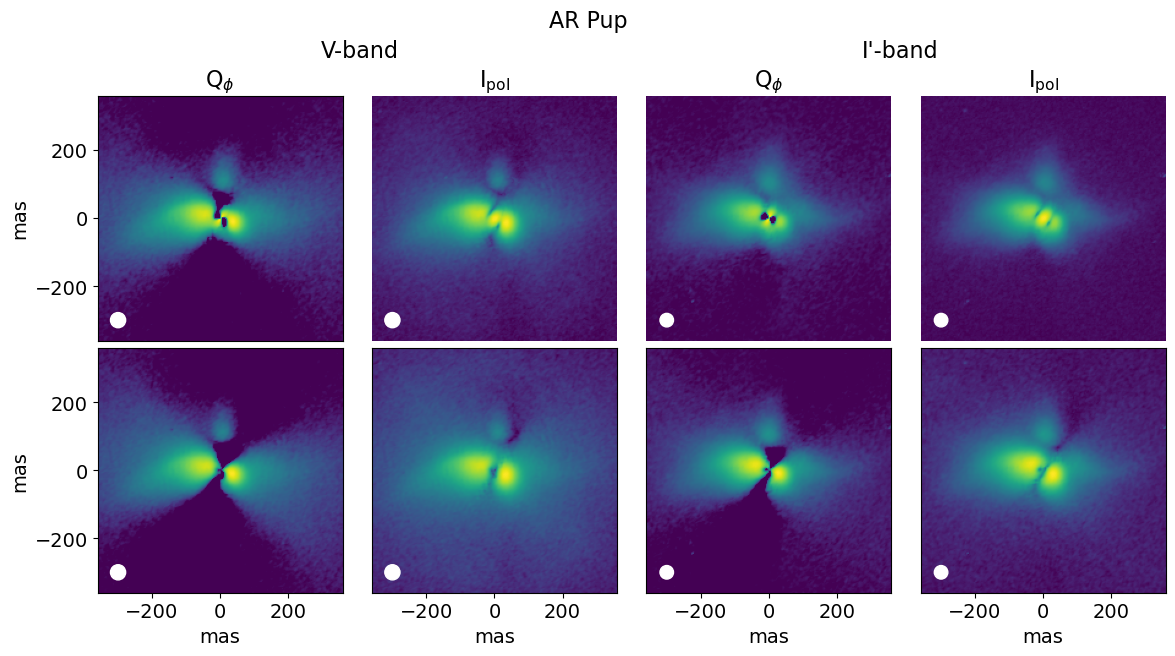

In [11]:

d = n * ps / 2
lim=50
if star==stars[0]: lim=100

fig, axs = plt.subplots(2, 4, figsize=(12, 6))
images_list=[q_phi_V_with_unres,pi_V_with_unres,q_phi_I_with_unres,pi_I_with_unres,q_phi_V,pi_V,q_phi_I,pi_I]
bandlist=['V','V','I','I','V','V','I','I']
for ax, image,band in zip(axs.flat,images_list,bandlist):
    
    image = np.arcsinh(image)
    max = np.max(image[int(n/2-lim/2):int(n/2+lim/2),int(n/2-lim/2):int(n/2+lim/2)])
    min=np.min(image[int(n/2-lim/2):int(n/2+lim/2),int(n/2-lim/2):int(n/2+lim/2)])
    
   
    ax.imshow(image, vmin=min, vmax=max, extent=(-d, d, d, -d))
    #plt.plot(0, 0, "+", color="red")
    ax.set_xlim(-lim * ps, lim * ps)
    ax.set_ylim(-lim * ps, lim * ps)
    ax.set_xlabel('mas',fontsize=14)
    ax.set_ylabel('mas',fontsize=14)
    #ax.set_yticks([-130,-100,-50,0,50,100])
    #ax.set_yticks(fontsize=14)
    ax.tick_params(axis='both',labelsize=14)
    if star==stars[0]: 
        circleloc=(-300,-300)
    else:
        circleloc=(-115,-115)
    if band=='V':
        circle1 =plt.Circle(circleloc, (fwhm_V/2), color='w')    
        ax.add_patch(circle1)
    else:
        circle1 =plt.Circle(circleloc, (fwhm_I/2), color='w')    
        ax.add_patch(circle1)
    

col_titles = ['Q$_\phi$', 'I$_{\mathrm{pol}}$', 'Q$_\phi$', 'I$_{\mathrm{pol}}$']


for ax, col_title in zip(axs[0], col_titles):
    ax.set_title(col_title, fontsize=16)

    
for i in range(3):
    axs[0,i+1].axis('off')  
    axs[1,i+1].get_yaxis().set_visible(False)
axs[0,0].get_xaxis().set_visible(False)

plt.tight_layout()
fig.text(0.5, 1.05, starnames[star], fontsize=16, ha='center')
fig.text(0.31, 1, 'V-band', fontsize=16, ha='center')
fig.text(0.76, 1, "I'-band", fontsize=16, ha='center')


plt.savefig(figfolder+star+'_unresolved.png',bbox_inches='tight')
plt.show()
plt.close()